In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading the Galileo E1 PRNs in hexadecimal format with a pandas dataframe
There exist two different kind of PRN codes for Galileo E1: E1B and E1C.
They are contained, in hexadecimal format, in the files called repectively "E1B - Gal.txt" and "E1C - Gal.txt"

For this simulation, we only consider the E1B PRNs:

In [2]:
filename = "E1B - Gal.txt"

# defining the name of the column of the dataframe called e1b
columns = ["Hexadecimal"]

#reading the file
e1b = pd.read_table(filename, sep='\n', header=None, names=columns)

# deleting the first 15 characters (not part of the code)
e1b['Hexadecimal'] = [el[16::] for el in e1b['Hexadecimal']]

# creating a new column with the codes indexes and placing it as first column
e1b['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1b = e1b.reindex(columns=column_list)

# printing the first lines of the dataframe
e1b.head()

,Code index,Hexadecimal
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...


In [3]:
# last code (just to verify if the loading operation is correct)
print(e1b['Hexadecimal'][49])

97051FC67ACA30E8AEE73D3A8CF38BB13524D4E0EBD9BE68398C7C16227CABB1D0B0A0ABE7B6384ABA02905BA0C3C7363599D059C7B4C99DB165CD14FA12FA7912449CA7DD5E346D8010C85A757382270DAD15BA3CE36A76EF55F81A1E80BF366B37FE3A88EC722028C25E234E624040450A99CD808F942568AA7133981D72E7F2928894670AD5399482DF1B90E7E64062F830B736C79C30F36281495C76699CD48404673FA334F042F9E0E67DD7F3853BF71ABEAF6A9A5546855E840CE42B224D8F6490C6CE5FC02EBAF4FFC390107058F54CD635D4A7F2878099C1EF495750E6921BE2F39AD808C4210F287319F811A254CEF8CF153FC50AB2F3D694A530949E5F578D075DB96DDCF2BB90ED3DE09D9CA8E08662FD8982741DE1CE0A6B64C3D3D5004B5C04B2B0DFD976A20FACC94D1762D41EE03B40D2CF367612812EF4CC41D1BFE9CEB51AE3A22AF1BE7B85A057D3048D0E73FA0FDAF1119EFD76F0A41BE63128B22D64A5553E9549D411483BBCA1483EF30CF6A6D317AD2C7973EFA6D4C1121F703D2F48FCDA3177AD450D75D2A28D2C244AEA13F0E60AEED8ACBAB444D400DF5E280DB799B2D9A984DF1E2567D39D1DE58EF78CA6B4D8BC172B07DCB02D156CA96EEFAC69E556CFCE0AAB617C7FBB8C34871C1D35E74B7BD307D3F2E424C7A9AD676A1A69E0FE735EA50887A1DFAE6CA2

In [4]:
# simple conversion from hexadecimal to binary
def hex2bin(h):
    integer = int(h, 16)
    binary = bin(integer)[2::]     #discarding the first two elements (i.e. 0b, not needed)
    binary = np.array([int(x) for x in binary])    #the binary representation is a numpy array of integers
    return binary
    
# creation of a new column of the dataframe with the binary representation of each PRN
e1b['Binary'] = e1b['Hexadecimal'].apply(hex2bin)
e1bcopy = e1b.copy()
e1b



,Code index,Hexadecimal,Binary
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ..."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."


In [5]:
print(e1b['Binary'][49])    # to verify if the conversion was successful, we print the last code in binary:

# since the last code starts with 9 7 ... in hexadecimal, the binary representation should start with 
# 1001 0111 ...
# and since it ends with ... 2 0, the binary representation should end with
# ... 0010 0000

[1 0 0 ... 0 0 0]


In order to generate the BOC(1,1) signal we need to modify the codes. Indeed, the sequence to modulate with the BOC(1,1) square subcarrier is obtained by applying a XOR between the data message and the PRN. Alternatively, obtaining the same result, it is possible to convert the binary sequences (both the data message and the PRNs) by considering a -1 instead of a 1 and by considering a 1 instead of a 0.

So the sequence 0 1 1 1 0 becomes 1 -1 -1 -1 1 (this example is valid for both the data message and the PRN). Then instead of applying a XOR we can simply multiply the data message and the PRN, the final result is the same.
Therefore now we create another dataframe where we store the modified PRNs.

In [6]:
def conversion(prn):
    new_prn = np.zeros(len(prn))
    for i in range(len(prn)):
        if prn[i] == 0:
            new_prn[i] = 1
        elif prn[i] == 1:
            new_prn[i] = -1
    return new_prn

e1bmodified = e1b.copy()
e1bmodified['Modified'] = e1bmodified['Binary'].apply(conversion)

e1bmodifiedcopy = e1bmodified.copy()
e1bmodified

,Code index,Hexadecimal,Binary,Modified
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0,..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ...","[-1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[-1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[-1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...","[-1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, ..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...","[-1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1...."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ...","[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...","[-1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...","[-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...","[-1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1..."


## Visualization of PRNs in time domain

In [7]:
# # function that plots a waveform corresponding to the first N chips of a certain prn code

# def plot_prn_zeros(N, prn):
    
#     Rc = 1.023e06   # chip rate
#     Tc = 1 / Rc     # chip period 

#     prn = prn[0:N]  # for visualization purposes, we plot only the first N chips of the prn code
    
#     # print("\nPrn to plot: ", prn, "\n")

#     # In order to plot the code we need a certain number of samples equal to the bit to represent. This is
#     # because, in order to obtain a waveform, we cannot just plot 1, then 0, then 1 etc. Instead, we need a certain
#     # number of samples equal to 1 (in order to see a continuous line), then a certain number of samples equal 
#     # to 0 etc.
#     # The number that was chosen is 10 (there are no particular reasons for this)

#     #time axis
#     t = np.linspace(0, N*Tc , 10*N)
#     m = np.zeros(10*N)
#     ticks = np.linspace(0, N*Tc, N+1)   
    
#     # In order to plot the code we need a certain number of samples equal to the bit to represent. This is
#     # because, in order to obtain a waveform, we cannot just plot 1, then 0, then 1 etc, Instead, we need a certain
#     # number of samples equal to 1 (in order to see a continuous line), then a certain number of samples equal 
#     # to 0, a certain number of samples equal to 1 etc.
#     # The number of samples to plot that was chosen is 10 (there are no particular reasons for this)

#     c = 0
#     for i in range(len(m)):
#         if i != 0 and i%10 == 0:
#             c = c + 1
#         m[i] = prn[c]

# #     fig = plt.figure(figsize=(15,5))
# #     plt.xticks(rotation=45)
# #     ax = fig.add_subplot(1,1,1)
# #     ax.plot(t, m, color='red', lw=5)
# #     ax.set_xticks(ticks)
# #     plt.xticks(rotation=45)
# #     ax.set_xlabel("time [s]", fontsize=20)
# #     ax.set_ylabel("Chip values", fontsize=20)
# #     title = "Chip values to plot: " + str(prn)
# #     ax.set_title(title, fontsize=20)
# #     ax.set_ylim(-0.1, 1.2)

# #     #plotting some dashed vertical lines in correspondance of consecutive chip periods
# #     for i in ticks:
# #         ax.vlines(i, 0, 1.15, color='black', ls='dashed', lw=1)
        
# #     #computing the middle value between consecutive chip periods, just to write the corresponding 
# #     #chip value in the exact position
# #     centers = 0.5*(ticks[1:] + ticks[:-1]) - 2e-7  #subtracting a small value to center it better wrt the figure
    
# #     #writing the value of each chip 
# #     for i,j in zip(centers, prn):
# #         ax.text(i, 1.07, j, fontsize=15)        

#     print("\nChip period Tc: ", Tc, "\n")
    
#     print(m)
#     print(len(m))
# # if we want to plot the first 30 chips of the first code in the e1b dataframe we need to write:
# plot_prn_zeros(4092, e1b['Binary'][0])

In [8]:
# # function that plots a waveform corresponding to the first N chips of a certain prn code

# def plot_prn_minus(N, prn):
    
#     Rc = 1.023e06   # chip rate
#     Tc = 1 / Rc     # chip period 

#     prn = prn[0:N]  # for visualization purposes, we plot only the first N chips of the prn code
    
#     for i in range(len(prn)):
#         if prn[i] == 0:
#             prn[i] = -1

#     # print("\nPrn to plot: ", prn, "\n")

#     # In order to plot the code we need a certain number of samples equal to the bit to represent. This is
#     # because, in order to obtain a waveform, we cannot just plot 1, then 0, then 1 etc. Instead, we need a certain
#     # number of samples equal to 1 (in order to see a continuous line), then a certain number of samples equal 
#     # to 0 etc.
#     # The number that was chosen is 10 (there are no particular reasons for this)

#     #time axis
#     t = np.linspace(0, N*Tc , 10*N)
#     m = np.zeros(10*N)
#     ticks = np.linspace(0, N*Tc, N+1)   
    
#     # In order to plot the code we need a certain number of samples equal to the bit to represent. This is
#     # because, in order to obtain a waveform, we cannot just plot 1, then 0, then 1 etc, Instead, we need a certain
#     # number of samples equal to 1 (in order to see a continuous line), then a certain number of samples equal 
#     # to 0, a certain number of samples equal to 1 etc.
#     # The number of samples to plot that was chosen is 10 (there are no particular reasons for this)

#     c = 0
#     for i in range(len(m)):
#         if i != 0 and i%10 == 0:
#             c = c + 1
#         m[i] = prn[c]

#     fig = plt.figure(figsize=(15,5))
#     plt.xticks(rotation=45)
#     ax = fig.add_subplot(1,1,1)
#     ax.plot(t, m, color='red', lw=5)
#     ax.set_xticks(ticks)
#     plt.xticks(rotation=45)
#     ax.set_xlabel("time [s]", fontsize=20)
#     ax.set_ylabel("Chip values", fontsize=20)
#     title = "Chip values to plot: " + str(prn)
#     ax.set_title(title, fontsize=20)
# #     ax.set_ylim(-0.1, 1.2)

#     #plotting some dashed vertical lines in correspondance of consecutive chip periods
#     for i in ticks:
#         ax.vlines(i, -1.15, 1.15, color='black', ls='dashed', lw=1)
        
#     #computing the middle value between consecutive chip periods, just to write the corresponding 
#     #chip value in the exact position
#     centers = 0.5*(ticks[1:] + ticks[:-1]) - 2e-7  #subtracting a small value to center it better wrt the figure
    
#     #writing the value of each chip 
#     for i,j in zip(centers, prn):
#         ax.text(i, 1.07, j, fontsize=15)        

#     print("\nChip period Tc: ", Tc, "\n")
    
    
# # if we want to plot the first 30 chips of the first code in the e1b dataframe we need to write:
# plot_prn_minus(15, e1b['Binary'][0])

[1 1 1 ... 0 1 0]


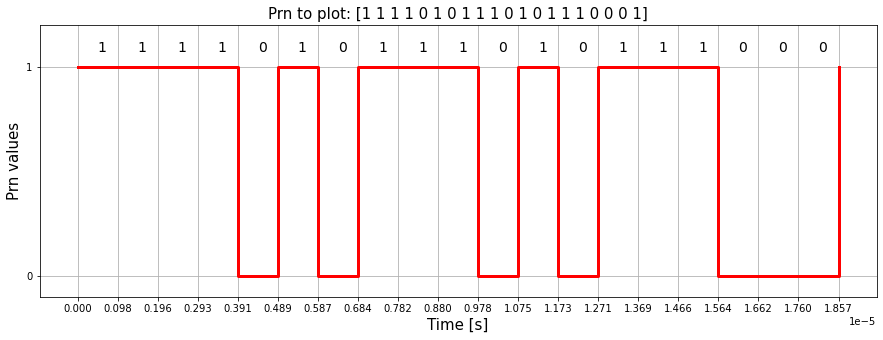

In [9]:
print(e1bcopy['Binary'][0])

def plot_prn_zeros(N, prn):
    
    Rc = 1.023e06   # chip rate
    Tc = 1 / Rc     # chip period 
    
    t = np.arange(0, N*Tc, Tc)
    
    xticks = t
    yticks = [0, 1]
    centers = 0.5*(xticks[1:] + xticks[:-1]) 
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(t, prn[0:N], where='post', color='red', lw=3)
    ax.set_xticks(t)
    ax.set_yticks(yticks)
    title = "Prn to plot: " + str(prn[0:N])
    ax.set_title(title, fontsize = 15)
    ax.set_ylim(-0.1,1.2)
    ax.set_xlabel("Time [s]", fontsize=15)
    ax.set_ylabel("Prn values", fontsize=15)
    ax.grid()
    for i,j in zip(centers, prn[0:N]):
        ax.text(i, 1.07, j, fontsize=14)   
        
plot_prn_zeros(20, e1bcopy['Binary'][0])

[-1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
  1. -1.]


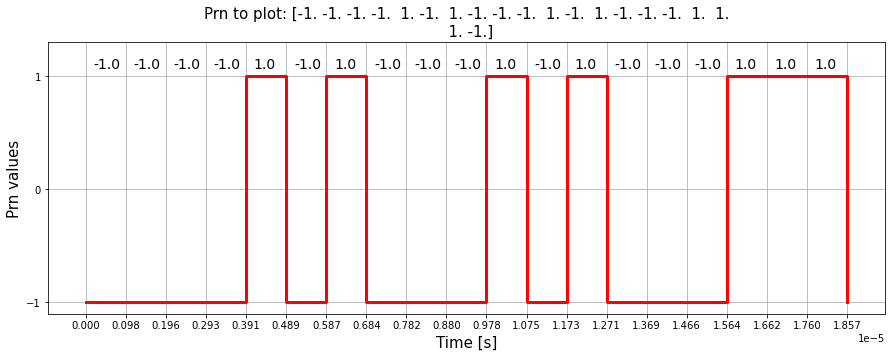

In [10]:
#this function plots the modified prns 

def plot_prn_modified(N, prn):
    
    Rc = 1.023e06   # chip rate
    Tc = 1 / Rc     # chip period 
    
    t = np.arange(0, N*Tc, Tc)
         
    xticks = t
    yticks = [-1, 0, 1]
    centers = 0.5*(xticks[1:] + xticks[:-1]) -3e-7
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(t, prn[0:N], where='post', color='red', lw=3)
    ax.set_xticks(t)
    ax.set_yticks(yticks)
    title = "Prn to plot: " + str(prn[0:N])
    ax.set_title(title, fontsize=15)
    ax.set_ylim(-1.1,1.3)
    ax.set_xlabel("Time [s]", fontsize=15)
    ax.set_ylabel("Prn values", fontsize=15)
    ax.grid()
    for i,j in zip(centers, prn[0:N]):
        ax.text(i, 1.07, j, fontsize=14)   

plot_prn_modified(20, e1bmodifiedcopy['Modified'][0])
print(e1bmodified['Modified'][0][0:20])

## BOC(1,1) Modulation

The BOC(1,1) modulation is obtained by multiplying 4 components:
- the data message we need to transmit (given by a sequence of bits with bit period Tb);
- the PRN sequence we use to spread the data message (given by a sequence of chips with chip period Tc);
- a square wave subcarrier with period Tp = Tc (due to n = m = 1)
- a sinusoidal carrier 

In [11]:
# # First of all we generate the subcarrier. In a BOC(1,1) modulation it is a NRZ (Non-return to zero) signal.

# def swap(x):
#     if x == 1:
#         x = -1
#     elif x == -1:
#         x = 1
#     return x


# Rc = 1.023e06
# Tc = 1 / Rc

# t = np.linspace(0, 5*Tc, 500)   #500 samples in total, 100 samples for each Tc, 50 samples for each +1 and -1 in a Tc
# #print(t)

# #generating the subcarrier: a NRZ square waveform made of 500 samples (THIS VALUE MUST BE CHANGED)
# subcarrier = []
# index = 0
# check = -1
# for i in range(500):
#     if(i % 50 == 0):
#         check = swap(check)
#     if(check == 1):
#         subcarrier.append(1)
#     if(check == -1):
#         subcarrier.append(-1)
    
# print("Length of subcarrier vector: ", len(subcarrier))

# xticks = [0]
# for i in range(1,6,1):
#     xticks.append(i*Tc)
    
# yticks = [-1,0,1]
    
# fig = plt.figure(figsize=(15,5))
# ax = fig.add_subplot(1,1,1)
# ax.plot(t, subcarrier, lw=2)
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# ax.set_xlabel("time [s]", fontsize=20)
# ax.set_ylabel("Subcarrier values", fontsize=20)
# ax.set_title("Subcarrier for BOC(1,1)", fontsize=20)
# # ax.hlines(0, 0, xticks[-1], color='black')
# ax.grid()

# # for i in xticks:
# #     ax.vlines(i, -1.15, 1.15, color='black', ls='dashed', lw=2)
    
# plt.show()

# print(subcarrier)

Subcarrier length:  4092


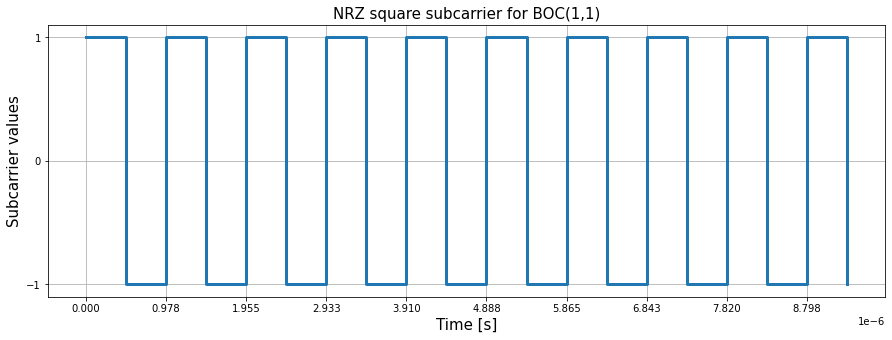

In [12]:
#Now we generate the BOC subcarrier, that is a square NRZ wave. The period of the waveform is given by Tc

Rc = 1.023e06   # chip rate
Tc = 1 / Rc     # chip period 

rep = 2046 
s = np.array([1, -1])
subcarrier = np.tile(s, rep) # we repeat the values 1 and -1 for 2046 times in order to have an array of 4092 elements, as the PRN codes
                             #probably the number of repetitions must be changed

#now we plot the first 20 samples of the subcarrier
xticks = np.arange(0,10*Tc, Tc)
yticks = [-1, 0, 1]

t = np.arange(0, 10*Tc, Tc/2)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.step(t, subcarrier[0:20], where='post', lw=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_title('NRZ square subcarrier for BOC(1,1)', fontsize=15)
ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel('Subcarrier values', fontsize=15)
ax.grid()

print("Subcarrier length: ", len(subcarrier))

In [33]:
#first we generate a random binary message of 80 bits (so it contains only zeros and ones)
message_len = 80
message = np.random.randint(0,2,message_len)

#substituting the 0 values with -1 values
for i in range(message_len):
    if message[i] == 0:
        message[i] = 1
    elif message[i] == 1:
        message[i] = -1
        
print(message)

[-1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1  1  1  1
  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1
 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1
  1 -1 -1  1 -1  1  1 -1]


In [42]:
#now we need to do the multiplication between the message data (80 bit) and the PRN, in order to spread the code


#The bit rate for GAL E1 is 250 symbols per second (equivalently, bits per second)
Rb = 250 
Tb = 1 / Rb   # the bit period is 4 ms

#in order to obtain the spread sequence we need to multiply the data signal with the PRN, but they have very 
#different lenghts. To do that, we need to repeat each symbol of the data message by a number of times that is 
# Tb/Tc so 4092. Basically each symbol of the data message will be repeated 4092 times. And then the first symbol
# of the spread sequence will be characterized by 4092 values, spaced apart by Tc seconds.
#Therefore the final spread sequence will have a length equal to 4092*80 = 327360

rep = 4092
spreaded = np.zeros(327360)
prn = e1bmodified['Modified'][0]

c = 0
for i in range(len(message)):
    for j in range(len(prn)):
        spreaded[c] = message[i]*prn[j]
        c = c+1
        
print(len(spreaded))

print("\nmessage:\n", message)
print("\nprn:\n", prn)

print("\nspreaded:\n", spreaded)

print("\n", spreaded[4092])

#we have just generated the spreaded sequence, made of 327360 values spaced apart by Tc

327360

message:
 [-1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1  1  1  1
  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1 -1
 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1
  1 -1 -1  1 -1  1  1 -1]

prn:
 [-1. -1. -1. ...  1. -1.  1.]

spreaded:
 [ 1.  1.  1. ... -1.  1. -1.]

 -1.0


### AWGN channel

In [ ]:
#This function simulaes the additive white gaussian noise channel. It takes as input the signal without the noise,
#the power of the noise in dB and a flag that allows the generation of the noise only if it is true.

def awgn(s, noise_power_dB, flag):
    length = len(s)
    if flag == True:
        noise = 10 ** (noise_power_dB/20) * np.random.randn(length)  
        #this returns gaussian samples drawn from the standard normal distribution, so with zero mean and unitary
        #variance. The zero mean is okay, but the variance of the noise should be equal to its power, so we need
        #to multiply by the standard deviation of the noise (that is the sqrt of the power, so the sqrt of
        #(10**noise_power_dB/10). That is why we put the multiplication factor there.
        s = s + noise
    return s

x = np.linspace(0,30,200)
y = np.cos(x)
p = awgn(y, -15, True)

#This is a random example, just to verify that it works
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(x,y,label='Without noise', lw=3)
ax.plot(x,p,label='With noise', lw=2)
ax.legend()
plt.show()